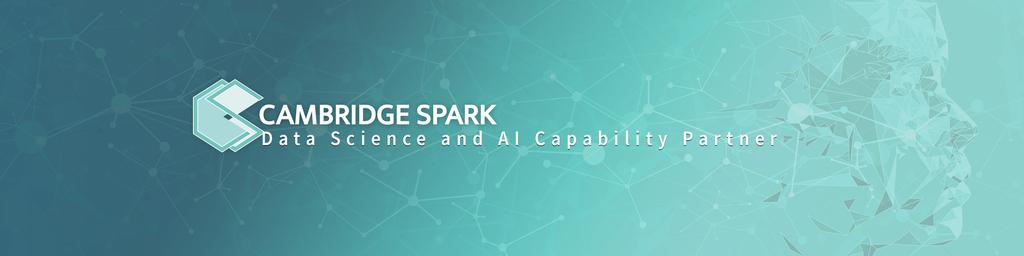

# Pandas Data Moderation and Cleaning

## Data aggregation, transformation and cleaning

### What is data processing?

> "... the collection and manipulation of data to produce new relevant information." 

*Source: [IT Pro](https://www.itpro.co.uk/business-operations/31681/what-is-data-processing)*

Arguably this could encompass elements throughout the **data lifecycle**, but here we are primarily concerned with:

- **Data aggregation**: *combining* data from several sources
- **Data transformation**: changing the *format* or *structure* of a dataset
- **Data cleaning**: dealing with *incomplete*, *incorrect*, or *inconsistent* values


## Concatenation

- The addition of one dataset to another
- Typically used to **extend** a dataset with extra rows or columns
- To achieve this we can use the pandas `.concat()` method

#### Concatenating DataFrames

In [ ]:
import numpy as np 
import pandas as pd
# import seaborn as sns # we'll use this later
# import matplotlib.pyplot as plt 

q1 = pd.read_csv('data/new-drugs-q1.csv')
q2 = pd.read_csv('data/new-drugs-q2.csv')
q3 = pd.read_csv('data/new-drugs-q3.csv')

Each file contains information about new prescription drugs made available in California during a given quarter of 2019 (based on data from [OSHPD](https://oshpd.ca.gov/visualizations/drugs-introduced-to-market/)).

In [ ]:
q1.head(5)

In [ ]:
q1.shape

In [ ]:
for q in [q1, q2, q3]:
    print(q.shape, q.columns)

- We have read the data and created a DataFrame from each CSV file
- We have confirmed that they contain the same columns in the same order

In [ ]:
df = pd.concat([q1, q2, q3], axis=0)

In [ ]:
print(df.shape)
df.head(3)

- We used the pandas `.concat()` method, passing a list of DataFrames as the only argument
- The `axis` parameter determines whether to concatenate along **rows** or **columns**
    - The default `0` is used here to combine rows from DataFrames with shared column names
    - `axis=1` would be used to extend a dataset with additional columns

In [ ]:
df.index

- Notice that the **index labels are unchanged** from what they were in each individual DataFrame, i.e. there are duplicated values
- We can create new unique row index labels if we want to by passing `ignore_index=True` to the `.concat()` method 

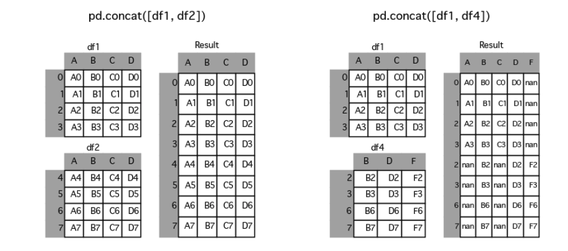

In [ ]:
df['NDC Number'].value_counts().max()

In [ ]:
df_new = df.set_index('NDC Number')
df_new.head(2)

- We can see from using the `.value_counts()` Series method that `NDC Number` contains no duplicate values
- We used the `.set_index()` method to use `NDC Number` as our index in a new DataFrame assigned to `df_new`

## Joining datasets

- We often need to **join** (combine) datasets which have some **relationship** with one another
- The relationship (or **association**) requires a common **key** in each dataset so that they can be combined

**one-to-one joins**   
Each dataset contains the same number of shared, unique values in the key
 
**many-to-one joins**   
The first dataset has numerous instances of one or more of the values in the key while the second datset only has one instance of each value

**many-to-many joins**  
Both datasets have numerous instances of one or more of the values in the key


#### Using the pandas `.merge()` method

pandas uses terminology borrowed from **SQL** (a popular language for **querying databases**) in the syntax for its methods which provide functionality for joining datasets. 

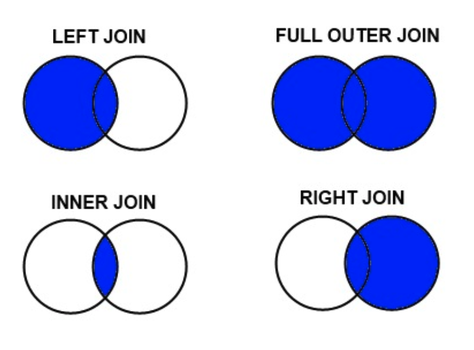

#### Examples of different joins with small datasets

There are several small DataFrames created in the `dataframes.py` file; let's take a look at two of them and then see how they can be merged:

In [ ]:
from dataframes import students, residents

display(students, residents)

We would like to add the `Age` column data to the `students` table:

In [ ]:
students.merge(residents, how="inner", left_on="Name", right_on="Name")

- `how=inner` means that only matches from the both tables are retained; no details for `Raoul` or `David` are used
- the `left_on` and `right_on` arguments are used to identify the column on which to join the tables
    - although here the column name is the same, they could be different in other scenarios

If we wanted to retain all of the names from the right table (`residents`), we can use `how="right"`:

In [ ]:
students.merge(residents, how="right")

- There is no data for `Subject` for `Raoul`, so this is returned as a `NaN` (missing value)

A similar result could be achieved by reversing the table order and using `left` instead of `right`:

In [ ]:
residents.merge(students, how="left")

- The only difference here is the column order
    - `Age` precedes `Subject` because `Age` was part of the `left` table, i.e. the table specified in the `how` argument

**Outer joins** will retain data found in one table but not the other. 

The `indicator` parameter is useful if we want to see which of the original tables the data in the other columns cam from:

In [ ]:
residents.merge(students, how="outer", indicator=True)

### Joining DataFrames using each index as the key

In [ ]:
data_a = pd.read_csv('data/drugs-data-a.csv', index_col='NDC Number')
display(data_a.head(4))
data_a.shape

- Notice how we used the `index_col` parameter with the pandas `read_csv()` method to use the values in the `NDC Number` column as our index
- The `.shape` DataFrame attribute tells us that there are less rows in `data_a` than our previous DataFrame `df_new`

In [ ]:
df_extra_on_index = df_new.merge(data_a, how='left', left_index=True, right_index=True)
df_extra_on_index.head(2)

- Here we used a **LEFT JOIN** (`how=left`), since we want to retain all data in the original DataFrame `df_new` and supplement it with associated data from the DataFrame `data_a`
- We used `left_index=True` and `right_index=True` to specify the `index` of each DataFrame as the **key** on which they will be joined
- We can see that the default values for the `suffix` parameter have been used, since there was a column in both of the DataFrames labelled `Date Introduced to Market`

### Joining DataFrames using multiple columns as the key

In [ ]:
df_extra = df_new.merge(data_a, how='left', on=['NDC Number', 'Date Introduced to Market'])
display(df_extra.head(2))
df_extra.shape

- Here we have used the `on` parameter to provide a **list of column labels** which are present in both DataFrames
- Notice that this list can include the **row index name** (in this case, `NDC Number`)
- By including `Date Introduced to Market` in the key, we only see one instance of the column in the resulting DataFrame

## Inner join

In [ ]:
df_extra_inner = df_new.merge(data_a, on=['NDC Number', 'Date Introduced to Market'])
display(df_extra_inner.head(2))
df_extra_inner.shape

- Using `.merge()` with the default `how` parameter results in an **INNER JOIN**
    - The resulting DataFrame has fewer rows; there were 79 rows with **matching keys**

## Right join

In [ ]:
df_extra_right = df_new.merge(data_a, how='right', on=['NDC Number', 'Date Introduced to Market'])
display(df_extra_right.head(2))
df_extra_right.shape

- Notice how in this instance the resulting DataFrame from a **RIGHT JOIN** is the same as that returned when using an **INNER JOIN**
    - This is to be expected if all of the keys in the right DataFrame are present in the left DataFrame

```Python
pd.merge(left, right, how='left', on=['key1', 'key2'])
```

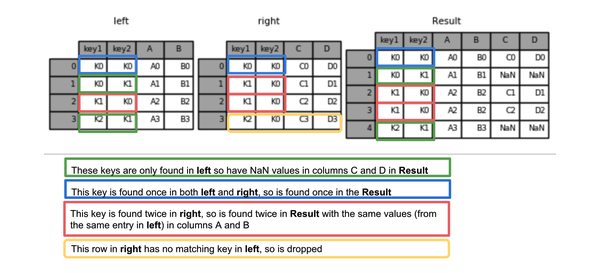

### pandas .merge() in detail

Let's work through the arguments (args) and keyword arguments (kwargs) for the DataFrame `.merge()` method found in the [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html):

```Python
DataFrame.merge(self, right, how='inner', 
                on=None, left_on=None, right_on=None, 
                left_index=False, right_index=False, 
                sort=False, suffixes=('_x', '_y'), 
                copy=True, indicator=False, validate=None)
```

```Python        
    DataFrame.merge(self, right,
                ```
        
- `self` refers to the **DataFrame** on which the method is being called, and is passed automatically to it; this DataFrame can be considered the **left** circle in each of the previous Venn diagrams
- `right` refers to the other **DataFrame** which we want to join with the original (left) DataFrame, and is represented by the right circle in the diagrams

```Python        
    DataFrame.merge(self, right, how='inner',
                ```

- `how` is the first **optional parameter** or **keyword argument**, all of which have default values
- The value given for `how` will determine how pandas attempts to **join** the two DataFrames
- In this case `inner` is the default value, which means that pandas will attempt an **inner join**

```Python
DataFrame.merge(self, right, how='inner', 
                on=None, left_on=None, right_on=None, 
                left_index=False, right_index=False, 
                ```
    
- The next parameters tell pandas which column(s) in each DataFrame contain(s) the **key** with which we want to join them
    - `on`, `left_on` and `right_on` can all take either a single label or a list of labels; where more than one label is used, **the values in all given columns in both DataFrames must match** for rows to be associated
    - `left_index` and `right_index` take Boolean values

- `on` gives us a way to associate the DataFrames using a single argument; useful if the key is in columns or indexes with the **same label in both DataFrames**
- if we don't use `on`, then we need to provide the key for each DataFrame separately:
    - For the **original** (left) DataFrame provide either `left_on=` with label(s) or `left_index=True`
    - For the **additional** (right) DataFrame provide either `right_on=` with label(s) or `right_index=True`

```Python
DataFrame.merge(self, right, how='inner', 
                on=None, left_on=None, right_on=None, 
                left_index=False, right_index=False, 
                sort=False, suffixes=('_x', '_y'), 
```

- `sort=True` would **sort** the resulting DataFrame by the **key**
- `suffixes` will append the given strings to any **column labels present in both DataFrames** (but not part of the key) so that they can be distinguished in the new DataFrame
    - **Consider adding these columns to the key** if they contain identical values; they will then only appear once in the new DataFrame

```Python
DataFrame.merge(self, right, how='inner', 
                on=None, left_on=None, right_on=None, 
                left_index=False, right_index=False, 
                sort=False, suffixes=('_x', '_y'), 
                copy=True, indicator=False, validate=None)
```    
- It's less likely that you will want to modify these keyword arguments, but:
    - `copy=False` could be used help to **save memory usage**
    - `indicator=True` adds a column giving information about the **source of each row** in relation to the join
    - `validate` allows checking of whether the merge is of a **specified type**, such as one-to-many, many-to-one

- As always, remember that you can and should refer to the [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) if:
    - You have an **unusual scenario** to deal with or your **output is not as expected**
    - You regularly use a given method - the **optional parameters** often provide a quick way to **carry out common further processing tasks**

## Jupyter Exercise

Merging datasets

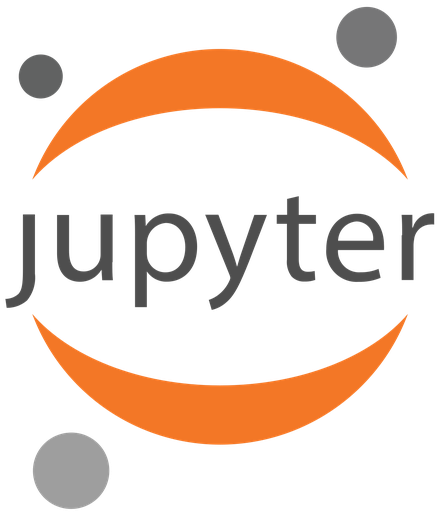

Open `processing-pandas-workbook.ipynb`

### Data Grouping and Aggregation

- We often need to calculate metrics for **subsets** (or groups) of our data
- A dataset can be **split** into **groups** of rows with common values in a given column
- **Calculations** can be **applied** to all groups simultaneously
- The **results** of these calculations can then be **combined** back together

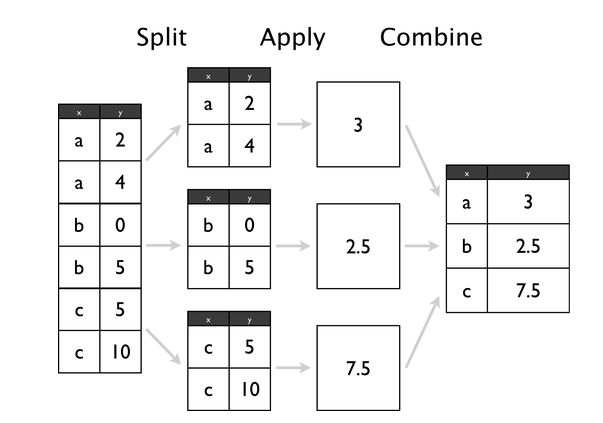
*Source: [Github](https://camo.githubusercontent.com/60a1e7e95eaef8f9a99f43335368915eafedda3e/687474703a2f2f7777772e686f66726f652e6e65742f737461743537392f736c696465732f73706c69742d6170706c792d636f6d62696e652e706e67)*

### Using the pandas `.groupby()` DataFrame method

In [ ]:
sac = pd.DataFrame({'x': ['a', 'a', 'b', 'b', 'c', 'c'], 'y': [2, 4, 0, 5, 5, 10]})
sac

In [ ]:
sac.groupby('x')[['y']].mean()

*with the `sac` DataFrame, `groupby` column `x` and calculate for column(s) `['y']` the `mean` of each group*

- In this particular example, the result would be the same with the omission of `[['y']]`; **if no columns are specified, the function is applied to all columns** in the DataFrame

- Using **[single parentheses]** is possible when only specifying a **single column** to perform the operation on, but will result in a **Series** rather than a DataFrame being returned

You're unlikely to need to use the following code snippets in isolation, but let's examine each to help clarify **Split - Apply - Combine**:

In [ ]:
gb = sac.groupby('x')
display(gb)
len(gb)

- the `.groupby()` method created a **groupby object**, which has a length of `3`, i.e. the number of groups it holds (`a`, `b`, and `c`)

In [ ]:
gb.get_group('a')

- The `get_group()` method of a groupby object allows us to access each individual group which has been created

In [ ]:
gb.get_group('a').mean()

- The original `.groupby()` statement applies an operation such as the `.mean()` method used above to each group and **combines the results** into a new DataFrame

Another example showing a different method (`.count()`) being applied, using a different column to group by:

In [ ]:
sac.groupby('y')[['x']].count()

- The **row index labels** show the **unique values** in column `y` of the original DataFrame, by which the values for column `x` have been grouped

## Example
Here's an example which applies the `.sum()`method to a subset of columns, with rows grouped by `Manufacturer Name`:

In [ ]:
# Quick cleaning process.

# Load data
df_data = pd.read_csv('data/drugs.csv', index_col='NDC Number')

# Drop columns 
cols_to_drop = ['Date Introduced to Market', 'Acquisition Date', \
                'Acquisition Price','Marketing/Pricing Plan Description',\
                'Acquisition Price Comment', 'General Comments', \
                'Supporting Documents']

df_cols = df_data.drop(cols_to_drop, axis=1)

# Filter incorrect values 
df_sub = df_cols[df_cols['Manufacturer Name']!='Kyowa Kirin, Inc.'].copy()

# Correct Indicator values with 0 as int
indicator_columns = df_sub.columns[df_sub.columns.str.contains("Indicator")]
df_sub[indicator_columns] = df_sub[indicator_columns].fillna(0).astype(int)

# Replace incorrect 0s as NaNs
df_sub['Estimated Number of Patients'] = df_sub['Estimated Number of Patients'].replace(0, np.nan)
df_clean = df_sub.copy()

In [ ]:
df_data = pd.read_csv('data/drugs.csv', index_col='NDC Number')

In [ ]:
indicators = df_data.groupby('Manufacturer Name')\
            [['Priority Review Indicator', 
              'Breakthrough Therapy Indicator',
              'Marketing/Pricing Plan Non-Public Indicator', 
              'Acquisition Price Non-Public Indicator']]\
            .sum()

indicators.tail(3)

In [ ]:
indicators.columns=[ 'Priority', 'Breakthrough', 'Marketing', 'Acquisition']
ind_total = indicators.sort_values(by=['Priority'], ascending=False)
ind_total.head(5)

- Here we have updated the column labels and used the `sort_values()` method to improve readability

### Using the pandas `.agg()` method

In [ ]:
ind_total.agg(['sum', 'mean'])

- Using `.agg()` on a DataFrame applies the **functions** in the **[list]** on every **column** (the `axis` parameter has a default value of `0`)

In [ ]:
ind_total.agg(['sum'], axis=1).sort_values(by='sum', ascending=False)\
         .rename(columns={'sum':'Total Indicators'}).head(3)

- `axis=1` applies the function(s) to each row
- The **function name** is used for the resulting **column label** by default; here we used the `.rename()` method to update it

### Combining `.groupby()` with `.agg()`

In [ ]:
manu_agg = df_data.groupby('Manufacturer Name')\
                   .agg(entries=('Manufacturer Name', 'size'), \
                        patient_estimates=('Estimated Number of Patients', 'count'))

manu_agg['missing_estimates'] = manu_agg['entries'] - manu_agg['patient_estimates']

manu_agg.sort_values(by='missing_estimates', ascending=False).head(3)

- Here we have used `.agg()` to **apply multiple functions** to a `groupby()` object
- Notice how each element in the tuple passed to `.agg()` is constructed as follows: 
```python
    result_column_name=('source_column', 'function')
```

- `'size'` returns the **number of values** in the given column, **including `NaN` values** (as such, the choice of column on which to apply it is unimportant, since all columns in a given DataFrame will have the same number)
- `'count'` **excludes `NaN` values**, so here the difference between the columns in `manu_agg` tells us how many entries do not have `patient_estimates` 

## Jupyter Exercise

Data grouping and aggregation

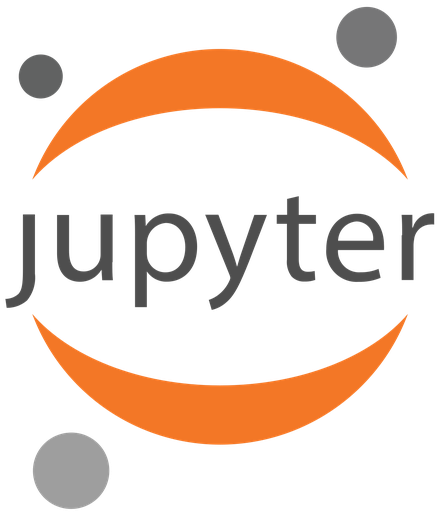

Open `processing-pandas-workbook.ipynb`

# Instrutor's Worked Titanic Example

In [ ]:
titanic = pd.read_csv('data/titanic.csv')

In [ ]:
titanic.head()

### Perform the initial EDA steps that you should consider whenever you load data into a dataframe.

- data shape
- data description
- data types
- missing values
- unique values and counts in categorical variables

In [ ]:
titanic.shape

In [ ]:
titanic.describe()

In [ ]:
titanic.dtypes

In [ ]:
titanic.isnull().sum()

In [ ]:
titanic['Embarked']

In [ ]:
titanic['Pclass'].value_counts()

## Intro to `.groupby()` in pandas

---

The built-in `.groupby()` function for dataframes is one of the most useful tools in pandas. As the name implies, `.groupby` will group your dataset by one or more user-specified column names given as an argument.

### Using `.groupby`, create a grouped dataframe where the titanic dataset is grouped by `Pclass`.

In [ ]:
grouped_by_classes = titanic.groupby('Pclass')

In [ ]:
grouped_by_classes

### Applying basic functions to groups

---

Pandas makes it easy to apply basic statistical functions to the grouped data with built-in functions. For example, if you have a grouped dataframe `grouped`:

```python
print(grouped.mean())
print(grouped.median())
print(grouped.count())
print(grouped.max())
```

We can get the mean, median, count, and max of the columns by group. 

### Try out these built-in functions on the grouped data you made above.

In [ ]:
grouped_by_classes.mean()

In [ ]:
grouped_by_classes.median()

In [ ]:
grouped_by_classes.count()

In [ ]:
grouped_by_classes.max()

You can also operate on single columns or subsets of columns across grouped dataframes using the indexing syntax for standard dataframes.

### Find the percent of passengers who survived by where they embarked.

In [ ]:
titanic.groupby('Embarked')['Survived'].mean()*100

### Print out the type of the grouped dataframe.

In [ ]:
type(grouped_by_classes)

Instead of a `DataFrame` object we now have a `DataFrameGroupBy` object. This operates somewhat differently than the DataFrame we are used to, as we shall see.

### Extract the names of the groups and the row indices contained in each.

Use the `.groups` attribute.

In [ ]:
grouped_by_classes.groups

### Extract the number of groups

Use the `.ngroups` attribute.

In [ ]:
grouped_by_classes.ngroups

### Determine the number of unique elements in each column per group.

Use the `.nunique()` method.

In [ ]:
grouped_by_classes.nunique()

### Pull out the first group from the grouped dataframe.

Use the `.get_group()` method with one of the group names.

In [ ]:
grouped_by_classes.get_group(1).head()

Grouped dataframes do not work in the same way as python lists. You can't pull out the different groups with indexers. Despite this, grouped dataframe objects **are** iterable! You can iterate over them using a for-loop, for example.

In our grouped dataframe, each element will be a tuple containing the Pclass group as its first element, and the subset of the original titanic dataframe for that Pclass as its second element.

### Write a for-loop to iterate through the grouped dataframe printing out the PClass and the header of the subset each time.

In [ ]:
for group, dataframe in grouped_by_classes:
    print(group)
    print(dataframe[['Pclass', 'Fare']].head(), '\n-----------------\n')

### Grouping by multiple fields

---

Grouping by more than one column is simple. The `.groupby()` function can take a list of column names to group by. When you group by more than one column, each subset of the data will correspond to one of the distinct combinations of the grouping columns.

### Create a grouped dataframe by grouping the titanic data by `Pclass` and `Survived`.

In [ ]:
newgrouped = titanic.groupby(['Pclass', 'Survived'])

### Print out the length of this grouped dataframe.

It is the same length as unique combinations of Pclass and Survied: 3 Pclasses by 2 Survival values.

In [ ]:
newgrouped.ngroups

In [ ]:
len(newgrouped)

In [ ]:
for group, dataframe in newgrouped:
    print(group)
    print(dataframe.head()[['Fare', 'Survived']], '\n----------------\n')

### Find the average fare and age grouped by the location of `Embarked` and the `Pclass`.

In [ ]:
fare_age = titanic.groupby(['Embarked', 'Pclass'])[['Fare', 'Age']].mean()
fare_age

### Have a look at the index structure.

Use the `.index` attribute.

In [ ]:
fare_age.index

In [ ]:
fare_age.loc[['Q', 'S'], [1, 2], :]

In [ ]:
fare_age.loc[(['Q', 'S'], [1, 2]), ['Fare', 'Age']]

### Removing the hierarchical index

---

By default pandas will give you back your groups in a hierarchical index format. If this is not preferable to you, you can use the `.reset_index()` function to take your row labels and convert them into columns.

### Remove the hierarchical index for the average fare and age dataset you just created, converting `Embarked` and `Pclass` to columns.

In [ ]:
fare_age.reset_index(inplace=True)

In [ ]:
fare_age

Or, alternatively, you can create the dataframe without the groupby columns as indices in the first place using the argument `as_index=False` inside `groupby()`.

### Find the mean of `Survived`, `Age`, and `Fare` grouped by `Sex` and then by `Pclass`.  Don't take the groupby variables as indices.

In [ ]:
titanic.groupby(['Sex', 'Pclass'], as_index=False)[
    ['Survived', 'Age', 'Fare']].mean()

### Applying your own functions to groups with `.apply()`

---

While pandas does contain a variety of useful built-in summary functions, it is common that you will need to apply a custom function to the data in your groups. 

The `.apply()` function takes a function as an argument and applies it to the subsets of data in your dataframe groups.

### See what happens when you replace the built-in `.mean()` function with  `.apply(np.mean)` for the question above.

In [ ]:
titanic.groupby(['Sex', 'Pclass'])[['Survived', 'Age', 'Fare']
                                   ].apply(np.mean).reset_index()

Say we wanted to have the mean of fare and age per `Embarked` and `Pclass`, but we wanted the numbers to be rounded. One way to do this would be to round the columns after we had applied the mean function as we did above. 

Another way would be to write a custom function to pass into apply. *The function passed to `.apply()` will be run on all of the subsets of data.*

### Write a function that will take the mean of columns in a dataset and round the values.

In [ ]:
def mean_and_round(x, a=2):
    mean = np.round(np.mean(x), a)
    return mean

### Apply your custom function to the grouped data.

In [ ]:
rounded_fare_age = titanic.groupby(['Embarked', 'Pclass'])[
    ['Fare', 'Age']].apply(mean_and_round, 1)

In [ ]:
rounded_fare_age

Functions that are applied to a dataframe and return a dataframe can also be applied to *groups* of dataframes.

### For example, write a function that will return the subset of the titanic dataset with the top paying female passengers.

In [ ]:
def top_n_females(df, n=5):
    female_subset = df.loc[df['Sex'] == 'female'].sort_values(
        'Fare', ascending=False)
    top_n_subset = female_subset[0:n]
    return top_n_subset

In [ ]:
top_n_females(titanic, n=3)

### Group the titanic data by `Survived` and apply your function to extract the top paying females.

In [ ]:
top_females_by_survival = titanic.groupby('Survived').apply(top_n_females, n=4)

In [ ]:
top_females_by_survival

### Basic pandas plots with grouped data

---

We can leverage the power of pandas even more by mixing its plotting capabilities with its grouping capabilities.

### First find the number of passengers per `Pclass` by using `.groupby` and `.size`.

In [ ]:
titanic.groupby('Pclass').size()

Here we have a series object with the counts of passengers per `Pclass` group. It is simple to get a plot of these counts by appending `.plot(kind="bar", color="g", width=0.85)`.

In [ ]:
titanic.groupby('Pclass').size().plot(kind='bar', color='g', width=0.85)
plt.xticks(rotation=0)
plt.show()

### Plot the average fare per `Sex` and `Pclass` as a bar chart.

In [ ]:
titanic.groupby(['Sex', 'Pclass'])['Fare'].mean().plot(
    kind='bar', color='r', width=0.85)
plt.xticks(rotation=45)
plt.show()

## Grouped bar charts with pandas

---

In the chart we just made, each bar represents an aggregate for each group. This is fine, but it would be  an even more informative chart if we colored according to group membership.

### Calculate the mean of `Fare` by `Pclass` and `Sex` using `groupby`, assign it to a variable, and print it out.

In [ ]:
fare_mean = titanic.groupby(['Pclass', 'Sex'])[['Fare']].mean()

In [ ]:
fare_mean

There is another built-in function for pandas objects called `.unstack()`. When we have a hierarchical index like we do above with `Pclass` as the broader category and `Sex` as the sub-category, the `.unstack()` command will attempt to move the subcategory from an index to column representation.

### Use the `.unstack()` function on your mean fare variable.

In [ ]:
fare_mean.unstack()

### Now use the plot function on the unstacked data to create a bar chart.

In [ ]:
fare_mean.unstack().plot(kind='bar', width=0.6)
plt.legend(['Female', 'Male'])
plt.xticks(rotation=0)
plt.show()

If you add the keyword variable `stacked=True`, it will stack the bars within the broader `Pclass` category.

In [ ]:
fare_mean.unstack().plot(kind='bar', width=0.6, stacked=True)
plt.legend(['Female', 'Male'])
plt.xticks(rotation=0)
plt.show()

### Using .agg( ) 

---

You can use `.agg()` on a groupby object to get different functions for different columns.

You want to create a dictionary with key-value pairs which look like `column_name:[list of functions]`

Many functions are built into Pandas and can be accessed by a string.

You can also put in lambda functions or functions that you defined elsewhere!

Or, instead of passing `.agg()` a dictionary, you can just pass it a list in which case it will apply every function in that list to each column you included in the groupby output.

In [ ]:
# convert according to made-up conversion, then find mean
def money_conversion_mean(x):
    converted = x/12 * 5
    return np.mean(converted)


titanic.groupby('Pclass').agg({'Survived': 'mean',
                               'Age': ['mean', 'median', 'count', 'std'],
                               'SibSp': [lambda x: np.mean(x)],
                               'Fare': ['mean', money_conversion_mean]})

In [ ]:
grouped_agg = titanic.groupby(['Sex', 'Pclass'])[
    ['Survived', 'Age', 'Fare']].agg(['mean', 'median', 'std'])
grouped_agg

### Explore the multi-index and the multi-column names.

Use the `.index` and the `.columns` attributes.

In [ ]:
grouped_agg.index

In [ ]:
grouped_agg.columns

#### Making use of the multi-index

With `iloc` we can refer to row and column positions.


In [ ]:
grouped_agg.iloc[3:6, 4:6]

With `loc` we can slice with names indicating the different levels and using `pd.IndexSlice`.

In [ ]:
idx = pd.IndexSlice

In [ ]:
grouped_agg.loc[idx['female', :2], idx['Age', :'median']]